In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt

In [4]:
def load_cv_results(models, base_dir, year=2017, trials=5, ext='', fluxes=False):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    radar_idx = dict()
    
    for i, (m, d) in enumerate(models.items()):

        # load predictions
        model_dir = osp.join(base_dir, m)
        result_list = []
        radar_idx_list = []
        for t in range(1, trials+1):
            file = osp.join(model_dir, f'test_{year}', d, f'trial_{t}', f'results{ext}.csv')
            if osp.isfile(file):
                df = pd.read_csv(file)
                df['trial'] = t
                result_list.append(df)
            
            radar_path = osp.join(osp.dirname(file), 'radar_index.pickle')
            if osp.isfile(radar_path):
                with open(radar_path, 'rb') as f:
                    radar_idx_list.append(pickle.load(f))
        radar_idx[m] = radar_idx_list
        results[m] = pd.concat(result_list)
        
        print(f'successfully loaded results for {m}')
        
        # load fluxes
        if fluxes and 'Flux' in m:
            m_fluxes = [dict(), dict()]
            for t in range(1, trials+1):
                sub_dir = osp.join(model_dir, f'test_{year}', d, f'trial_{t}')
                          
                with open(osp.join(sub_dir, f'radar_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[0][t] = pickle.load(f)
                          
                with open(osp.join(sub_dir, f'model_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[1][t] = pickle.load(f)
    
            all_fluxes[m] = m_fluxes

    return results, bird_scales, all_fluxes, radar_idx

In [5]:
def compute_rmse(m, results, groupby='fold', threshold=0, km2=True):
    
    ext = '_km2' if km2 else ''
        
    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}')
    rmse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    rmse = rmse.reset_index(name='rmse')
    rmse['model'] = m
    
    return rmse

In [6]:
def plot_fluxes(voronoi, G, all_fluxes, results, fold=0, model=1, context=24, horizon=64, bird_scale=1, 
                net_fluxes=False, abm=False, ax=None, crs=None, max_flux=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    if abm:
        f = np.concatenate([f[..., :horizon+1] for f in all_fluxes.values()], axis=-1)
        mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes))])
    else:
        print(len(all_fluxes[fold]), results.horizon.unique())
        if model:
            f = torch.cat([f for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        else:
            f = torch.cat([f[..., context:context+horizon] for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        mask = np.concatenate([results.query(f'seqID == {i} & horizon >= {context}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[fold]))])


    #radars = results.radar.unique()
    radars = voronoi.radar.values
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask]) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask])
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0 and i !=j :
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    max_flux = max(max_flux, fluxes.max())
    norm = plt.Normalize(0, max_flux)
    #print(fluxes.min(), fluxes.max())
    #print(nx.get_edge_attributes(G_new, 'flux'))
    edge_colors = cmap(norm(fluxes))

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    if abm:
        ax.set(title='averaged simulated fluxes between radars')
    else:
        ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, ax, max_flux

In [5]:
base_dir = '/home/fiona/birdMigration/results/abm'

In [7]:
models = ['GAM', 'LocalMLP', 'LocalLSTM', 'FluxGraphLSTM']
ext = '_fixedT0'
all_rmse = []
all_rmse_per_h = []
for m in models:
    all_rmse.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_fold_thr0{ext}.csv')))
    all_rmse_per_h.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_hour_thr0{ext}.csv')))
df_rmse = pd.concat(all_rmse)
df_rmse_h = pd.concat(all_rmse_per_h)

In [ ]:
models = {'GAM': 'final_evaluation', 'GBT': 'final_evaluation'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='', fluxes=False, trials=1)

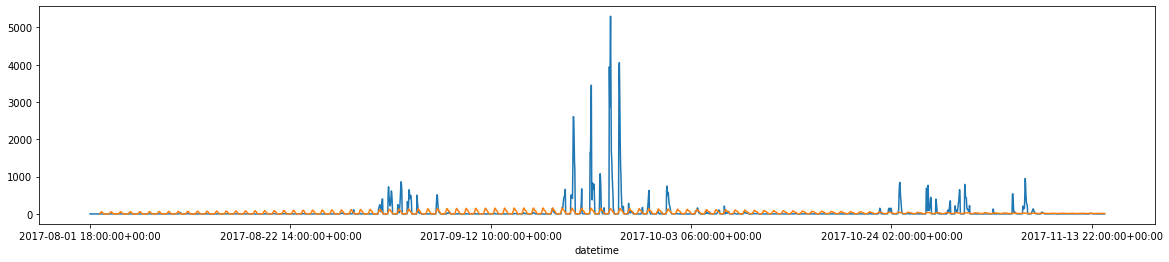

In [22]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'frniz'
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax)
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax)
r['GBT'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax)